In [4]:
import pandas as pd
import numpy as np

# Step 1: Specify the path to `BM2425.xlsx` in your local system
file_path = '/Users/marclambertes/Python/Matches/Women/2024-2025/Leagues - Project/Pass/France - Pass.xlsx'  # Update with the actual file path on your system

# Step 2: Load the file directly from the local system
data = pd.read_excel(file_path, usecols=['playerName', 'contestantId', 'x', 'y', 'endX', 'endY', 'outcome', 'typeId'], nrows=1000)

# Step 3: Filter for passes (e.g., typeId == 1) and defensive actions (e.g., typeId == 7 or 8)
passes = data[data['typeId'] == 1]  # Assuming typeId == 1 indicates passes
defensive_actions = data[data['typeId'].isin([7, 8])]  # Assuming typeId == 7, 8 are defensive actions

# Identify receivers based on outcome == 1 and next action by a different player
passes['receiverName'] = None
for idx, pass_row in passes.iterrows():
    if pass_row['outcome'] == 1:
        subsequent_actions = data[(data['x'] == pass_row['endX']) & (data['y'] == pass_row['endY']) & (data['playerName'] != pass_row['playerName'])]
        if not subsequent_actions.empty:
            passes.at[idx, 'receiverName'] = subsequent_actions.iloc[0]['playerName']

# Add Pressure successful column
passes['Pressure successful'] = passes['receiverName'].apply(lambda x: 'no' if pd.notna(x) else 'yes')

# Define a threshold for distance calculations
threshold = 10  # Define a threshold in meters

# Function to calculate distance weight
def calculate_distance_weight(distance, max_distance=threshold):
    return max(0, 1 - distance / max_distance)  # Weight decreases linearly with distance

matched_actions = []

for _, pass_row in passes.iterrows():
    for _, def_row in defensive_actions.iterrows():
        # Ensure defender belongs to a different contestantId
        if pass_row['contestantId'] != def_row['contestantId']:
            # Check spatial proximity
            distance = np.sqrt((pass_row['endX'] - def_row['x']) ** 2 + (pass_row['endY'] - def_row['y']) ** 2)
            if distance <= threshold:
                # Calculate metrics
                pre_action_danger = 1 - (
                    0.02 * distance +
                    0.1 * np.abs(np.arctan2(pass_row['endY'] - pass_row['y'], pass_row['endX'] - pass_row['x']))
                )
                pre_action_danger = max(0, min(1, pre_action_danger))  # Clip between 0 and 1
                post_action_danger = pre_action_danger * (0.5 if def_row['outcome'] == 1 else 1.0)

                # Calculate distance weight
                distance_weight = calculate_distance_weight(distance)

                # Adjust xDef with distance weight
                xDef = (pre_action_danger - post_action_danger) * distance_weight

                # Calculate xPass for the pass
                xPass = 1 - (
                    0.02 * distance +
                    0.1 * np.abs(np.arctan2(pass_row['endY'] - pass_row['y'], pass_row['endX'] - pass_row['x']))
                )
                xPass = max(0, min(1, xPass))  # Clip xPass to be between 0 and 1

                matched_actions.append({
                    'passer': pass_row['playerName'],
                    'receiver': pass_row['receiverName'],
                    'Pressure successful': pass_row['Pressure successful'],
                    'defender': def_row['playerName'],
                    'xPass': xPass,
                    'pre_action_danger': pre_action_danger,
                    'post_action_danger': post_action_danger,
                    'xDef': xDef,
                    'distance_weight': distance_weight,
                    'pass_start': (pass_row['x'], pass_row['y']),
                    'pass_end': (pass_row['endX'], pass_row['endY']),
                    'defensive_action': (def_row['x'], def_row['y']),
                    'distance': distance
                })

# Step 4: Save results to a DataFrame
matched_df = pd.DataFrame(matched_actions)

# Step 5: Save results directly to a file in your local system
output_filename = 'Matched_Passes_With_Defensive_Actions_Threshold_10_Meters.xlsx'
matched_df.to_excel(output_filename, index=False)

print(f"Results saved locally at '{output_filename}'")

# Optional: Print a preview of the results
print("Preview of Matched Actions:")
print(matched_df.head())


/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_69979/3080260880.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes['receiverName'] = None
/var/folders/68/mhmqcpdn52943pyql2n4wj440000gn/T/ipykernel_69979/3080260880.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes['Pressure successful'] = passes['receiverName'].apply(lambda x: 'no' if pd.notna(x) else 'yes')


Results saved locally at 'Matched_Passes_With_Defensive_Actions_Threshold_10_Meters.xlsx'
Preview of Matched Actions:
            passer receiver Pressure successful       defender     xPass  \
0      E. Guessand     None                 yes      J. Lefort  0.596411   
1      E. Guessand     None                 yes      J. Aholou  0.577229   
2  Y. Ndayishimiye     None                 yes  C. Hountondji  0.650183   
3  Y. Ndayishimiye     None                 yes      J. Lefort  0.684623   
4      T. Ndombélé     None                 yes    Y. Belkhdim  0.582878   

   pre_action_danger  post_action_danger      xDef  distance_weight  \
0           0.596411            0.298205  0.032200         0.107980   
1           0.577229            0.288615  0.003484         0.012073   
2           0.650183            0.325092  0.010894         0.033512   
3           0.684623            0.684623  0.000000         0.205708   
4           0.582878            0.582878  0.000000         0.118581   

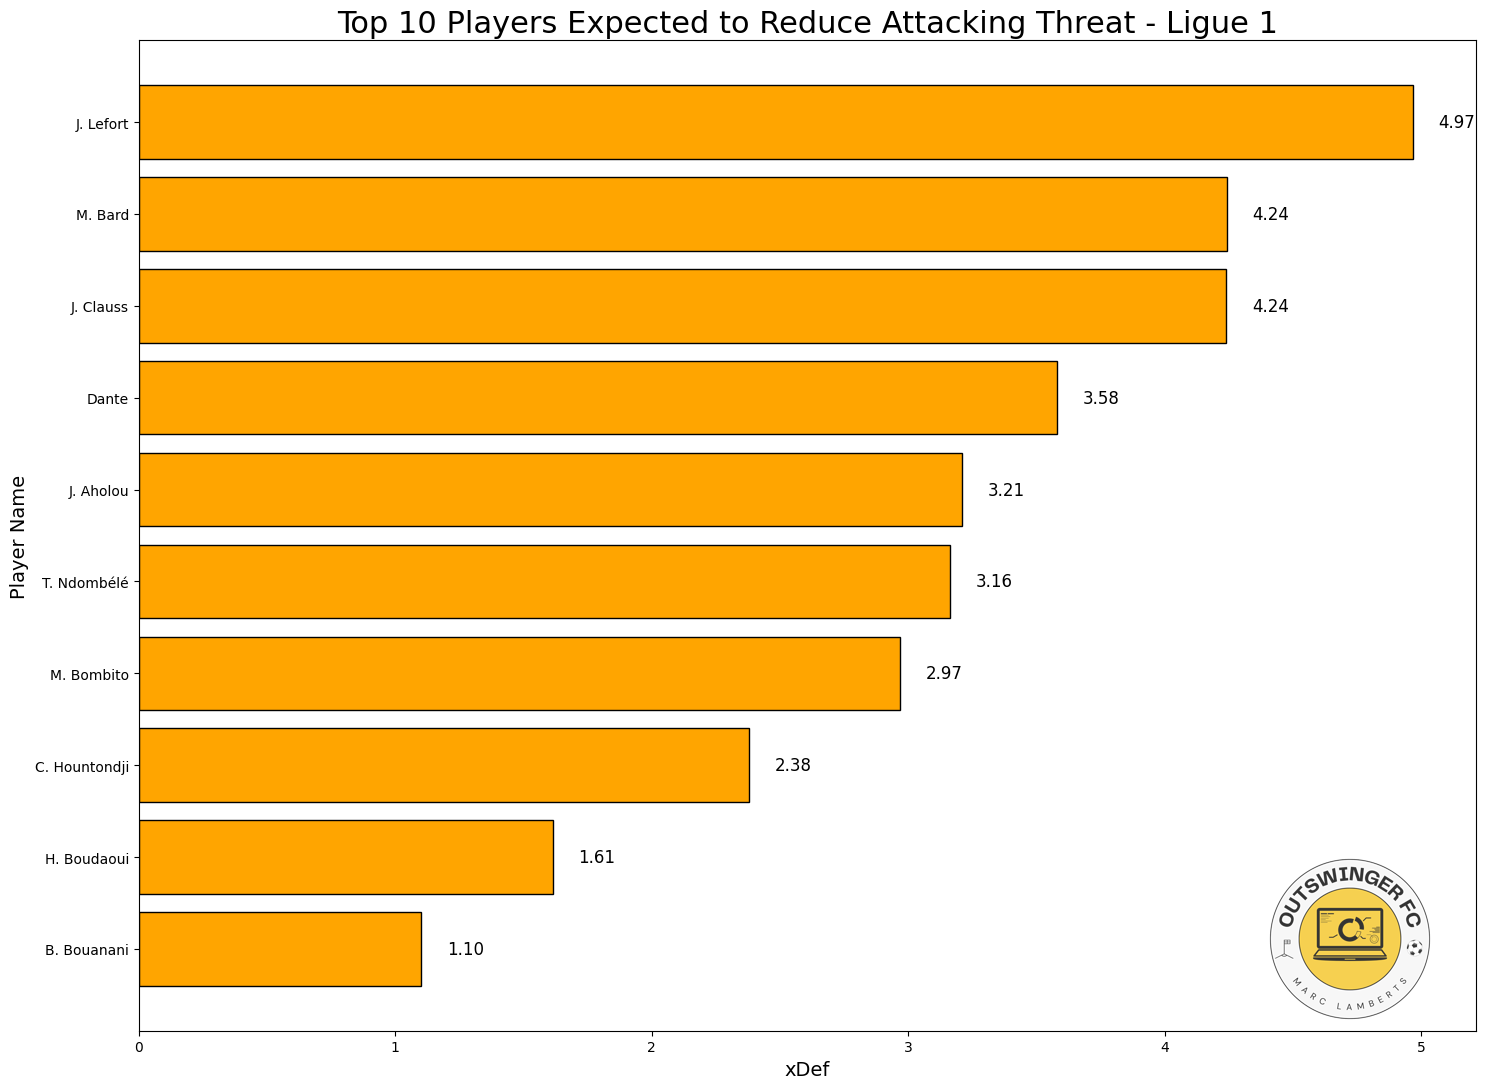

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg

# Load the Excel file
input_file = 'Matched_Passes_With_Defensive_Actions_Threshold_10_Meters.xlsx'  # Replace with your actual file path
data = pd.read_excel(input_file)

# Sum xDef for each unique defender
defender_impact = data.groupby('defender')['xDef'].sum().reset_index()

# Sort by xDef and select the top 10
top_defenders = defender_impact.sort_values(by='xDef', ascending=False).head(10)

# Plot bar chart
plt.figure(figsize=(15, 11))
bars = plt.barh(top_defenders['defender'], top_defenders['xDef'], color='orange', edgecolor='black')

# Add values at the end of each bar with a small offset
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.1,  # Add offset to the width
        bar.get_y() + bar.get_height() / 2,
        f'{width:.2f}',  # Format the value to 2 decimal places
        va='center', ha='left', fontsize=12
    )

# Labels and title
plt.xlabel('xDef', fontsize=14)
plt.ylabel('Player Name', fontsize=14)
plt.title('Top 10 Players Expected to Reduce Attacking Threat - Ligue 1', fontsize=22)
plt.gca().invert_yaxis()  # Invert Y-axis for better readability

# Add a logo in the bottom-right corner, moved slightly to the left
logo_path = 'Outswinger FC (3).png'  # Replace with the path to your logo file
logo_img = mpimg.imread(logo_path)  # Read the logo image
plt.figimage(logo_img, xo=plt.gcf().get_size_inches()[0] * plt.gcf().dpi - 250,  # Adjust `xo` for left movement
             yo=50, zorder=3, alpha=0.8)  # Adjust `yo` for vertical placement

# Save the plot as a PNG file
output_file = 'Top_10_Defenders_xDef.png'  # Replace with your desired file name
plt.savefig(output_file, format='png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


/Users/marclambertes/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


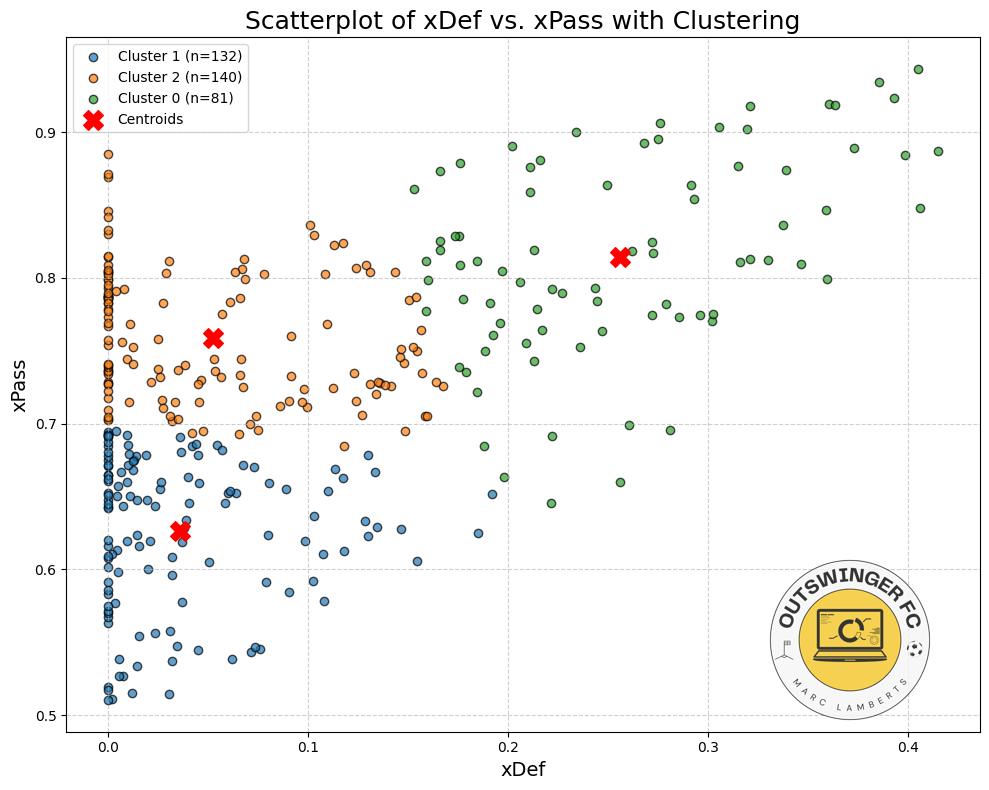

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.image as mpimg

# Load the Excel file
input_file = 'Matched_Passes_With_Defensive_Actions_Threshold_10_Meters.xlsx'  # Replace with your actual file path
data = pd.read_excel(input_file)

# Prepare data for clustering (xDef and xPass)
clustering_data = data[['xDef', 'xPass']].dropna()

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters for the desired number of clusters
clustering_data['Cluster'] = kmeans.fit_predict(clustering_data)

# Plot scatterplot with clusters
plt.figure(figsize=(10, 8))
cluster_counts = clustering_data['Cluster'].value_counts()  # Count the number of points in each cluster
for cluster in clustering_data['Cluster'].unique():
    cluster_points = clustering_data[clustering_data['Cluster'] == cluster]
    plt.scatter(
        cluster_points['xDef'],
        cluster_points['xPass'],
        label=f'Cluster {cluster} (n={cluster_counts[cluster]})',  # Add count to the legend
        alpha=0.7,
        edgecolor='black'
    )

# Add cluster centroids
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    s=200,
    c='red',
    marker='X',
    label='Centroids'
)

# Add labels, legend, and title
plt.xlabel('xDef', fontsize=14)
plt.ylabel('xPass', fontsize=14)
plt.title('Scatterplot of xDef vs. xPass with Clustering', fontsize=18)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Add a logo in the bottom-right corner
logo_path = 'Outswinger FC (3).png'  # Replace with the path to your logo file
logo_img = mpimg.imread(logo_path)  # Read the logo image
plt.figimage(logo_img, xo=plt.gcf().get_size_inches()[0] * plt.gcf().dpi - 250,  # Adjust `xo` for left movement
             yo=50, zorder=3, alpha=0.8)  # Adjust `yo` for vertical placement

# Save the scatterplot as a PNG file
output_file = 'Scatterplot_xDef_vs_xPass_Clusters_with_Logo.png'  # Replace with your desired file name
plt.savefig(output_file, format='png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()
